In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms
import numpy as np
import scipy.ndimage as ndimg
from PIL import Image
from matplotlib import pyplot as plt
from dataset import *
from copy import deepcopy

Creating a Model

In [2]:
class DetectionModel(nn.Module):
    def __init__(self):
        super(DetectionModel, self).__init__()
        self.core = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.core.fc.in_features, 2),
            nn.LogSoftmax(dim=1)
        )
        for parameters in self.core.parameters():
            parameters.requires_grad = False
        self.core.fc = self.classifier
    def forward(self, x):
        return self.core(x)
    
    def train(self, loaders, epochs):
        self.core = self.core.cuda()
        opt = optim.Adam(self.core.fc.parameters())
        lr_modifier = optim.lr_scheduler.StepLR(opt, 4)
        criterion = nn.NLLLoss()
        best_model = deepcopy(self.core.state_dict())
        best_accuracy = 0.0
        
        for epoch in range(epochs):
            print(f"{epoch + 1}/{epochs}")
            line = "_"
            print(line * 50)

            phases = ["train", "test"]
            for phase in phases:
                if phase == "train":
                    lr_modifier.step()
                    self.core.train
                else:
                    self.core.eval()
                
                curr_loss = 0.0
                curr_num_correct = 0

                for inputs, labels in loaders[phase]:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    opt.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        out = self.core(inputs)
                        _, predictions = torch.max(out, 1)
                        loss = criterion(out, labels)
                        if phase == "train":
                            loss.backward()
                            opt.step()
                    curr_loss += loss.item() * inputs.size(0)
                    curr_num_correct += torch.sum(predictions == labels.data)
                epoch_mean_loss = curr_loss / dataset_sizes[phase]
                epoch_mean_accuracy = curr_num_correct.double() / dataset_sizes[phase]
                print("{}: Loss:{:.4f}, Acc: {:.4f}".format(phase, epoch_mean_loss, epoch_mean_accuracy))
                if phase == "test" and epoch_mean_accuracy > best_accuracy:
                    best_accuracy = epoch_mean_accuracy
                    best_model = deepcopy(self.core.state_dict())
        print('Best validation Acc: {:4f}'.format(best_accuracy))
        self.core.load_state_dict(best_model)
        return self.core


In [3]:
model = DetectionModel()
trained_model = model.train(loaders, 10)

c:\Users\joshu\.conda\envs\hack\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\joshu\.conda\envs\hack\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/10
__________________________________________________


c:\Users\joshu\.conda\envs\hack\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: Loss:0.3846, Acc: 0.8401
test: Loss:0.6149, Acc: 0.6811
2/10
__________________________________________________
train: Loss:0.2531, Acc: 0.9036
test: Loss:0.4437, Acc: 0.7981
3/10
__________________________________________________
train: Loss:0.1892, Acc: 0.9235
test: Loss:0.4438, Acc: 0.7997
4/10
__________________________________________________
train: Loss:0.1770, Acc: 0.9316
test: Loss:0.4353, Acc: 0.8077
5/10
__________________________________________________
train: Loss:0.1771, Acc: 0.9302
test: Loss:0.4422, Acc: 0.8045
6/10
__________________________________________________
train: Loss:0.1732, Acc: 0.9321
test: Loss:0.4352, Acc: 0.8093
7/10
__________________________________________________
train: Loss:0.1687, Acc: 0.9352
test: Loss:0.4546, Acc: 0.7997
8/10
__________________________________________________
train: Loss:0.1734, Acc: 0.9329
test: Loss:0.4498, Acc: 0.8029
9/10
__________________________________________________
train: Loss:0.1695, Acc: 0.9339
test: Loss:0.446

Class for getting the last convolutional layer

In [4]:
class ConvActs():
    def __init__(self, model):
        self.features = []
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_function))
    def hook_function(self, module, inputs, outputs):
        self.features.append(outputs)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

Generating activation Map

In [5]:
def load_img(img_path):
    img = Image.open(img_path).convert("RGB")
    transform_loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    img = transform_loader(img).float()
    img = img.unsqueeze(0)
    return img

trained_model = model.core
activations = ConvActs(trained_model)
img_path = "C:/Users/joshu/Python Projects/Machine Learning Projects/HackAppletonProject/Xray_Imgs/IM-0143-0001.jpeg"
img = load_img(img_path)
prediction_with_log_softmax = trained_model(img.cuda())
output_features = activations.features[0].squeeze(0)    
output_features = np.transpose(output_features.cpu(), (1, 2, 0))
prediction_with_softmax = torch.exp(prediction_with_log_softmax)
prediciton = np.argmax(prediction_with_softmax.cpu().detach())
GAP_weights = trained_model.fc[0].weight
weights = GAP_weights[prediciton, :]
activation_map = np.dot(output_features.detach(), weights.detach().cpu())
class_activation_map = ndimg.zoom(activation_map, zoom=(32, 32), order=1)

Display Images with activation maps

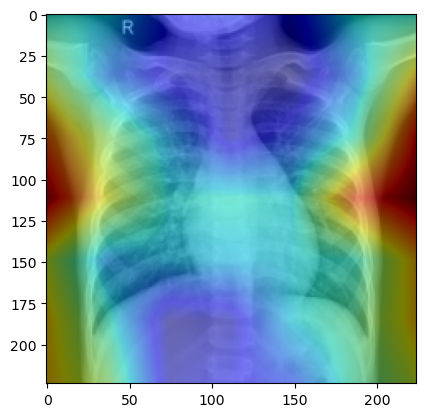

In [6]:
img = np.squeeze(img, axis=0)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img, cmap='jet', alpha=1)
plt.imshow(class_activation_map, cmap='jet', alpha=0.5) 